<a href="https://colab.research.google.com/github/Nina-Om/ArcGIS-MapBook-Toolbox/blob/master/Regional_ECMWF_forecast_BOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***This notebook processes monthly ECMWF hindcast (1981-2016) and forecast data (2017 to present), focusing on selected variables on `Single` or `Pressure` `Level`. It clips these datasets to the AZ_East, AZ_West, NM_South and NM_North regions and calculates mean areal values for each variable within these areas.*** \\


**Author**: Nina Omani \
**Date created**: 5/9/2024  \

**Data download:** \\
[Seasonal forecast monthly statistics on single level](https://cds.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=download) \\
[Seasonal forecast monthly statistics on pressure level](https://cds.climate.copernicus.eu/datasets/seasonal-monthly-pressure-levels?tab=download)

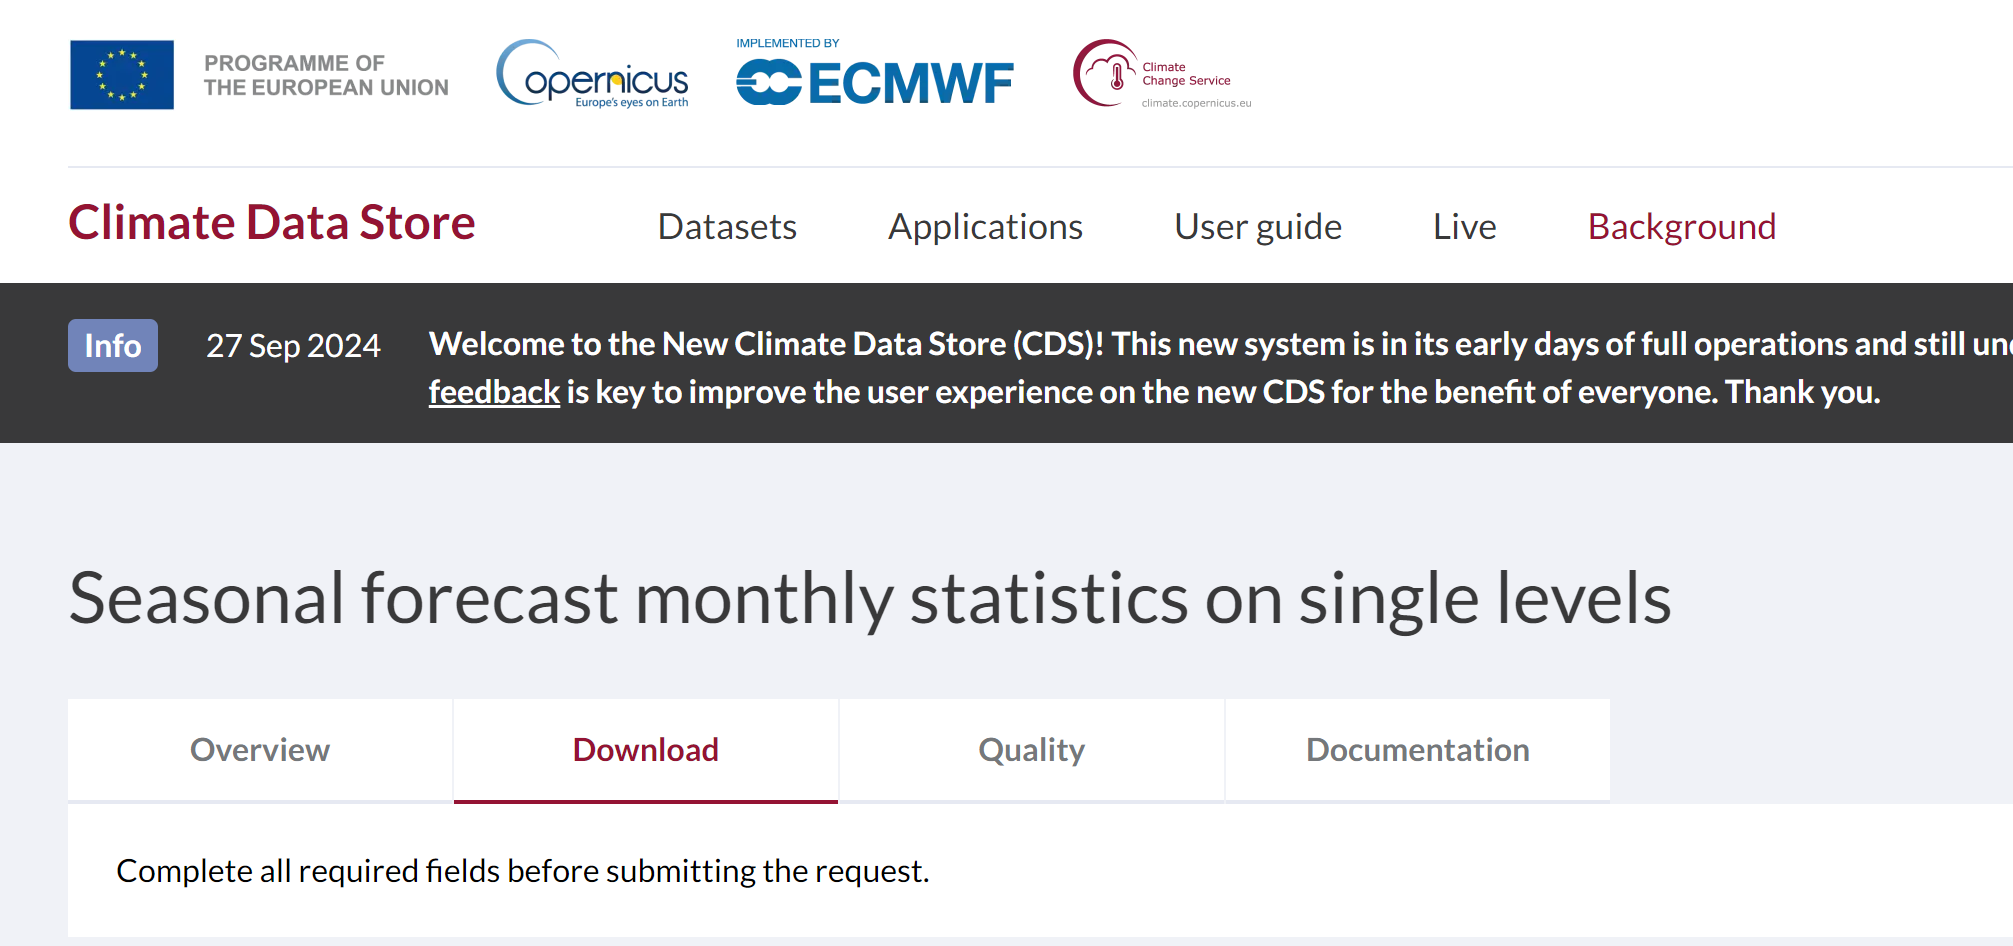

Please follow these steps to download the data:


*   select ECMEF in the "Originating centre" field
*   select "51" (model version 51) in the "System" field
*   select interested variable under "Variable" field

```
        Specific humidity (Q) at Pressure Level 850 hPa
        Total column cloud liquid water (single level)
        Total column water vapour (single level)
        Total precipitation (single level)
```

*   selecgt "Monthly mean" under "Individual members" field.
*   select the years of interest in the "Year" field
*   select the month of interest in the "Month" field (e.g. months from June to October).
* select all fields in the "Leadtime hour" field.
* set the following "Geographical area": N = 40, W = -116, S = 30, E = -109
* select GRIB in "Format" field
* Click on "Submit Form" \
You will be forwarded to the "Your requests" page, which allows you to download the data after it has been processed. Here we will take a shortcut and download a pre-compiled ECMWF forecast from Google Drive. The data is available to be downloaded from Google Drive for **1981-Oct2024 (init_month=4 April)**. Your data will be appended to this data.

If you want to use the data that you downloaded from Copernicus, click on the folder item on the left side of the screen and upload the data from your local machine or Google Drive. You can also upload your data through this notebook following the next steps.

In [ ]:
#Install the packages if required
!pip install netCDF4
!pip3 install cfgrib
!pip install ecmwflibs
!pip install --upgrade xarray
!pip3 install eccodes
!pip install geopandas rasterio regionmask
!pip install cartopy
!pip install gdown

In [ ]:
#import datetime
#from datetime import datetime
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr
import cfgrib
import ecmwflibs
import eccodes
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from pprint import pprint
import re  # Regular expressions
import multiprocessing as mp
import rasterio
import regionmask
from functools import reduce
import seaborn as sns
import gdown

In [ ]:
# Functions

def plot_all_points_on_single_map(coordinates_dict, shapefiles, buffer):
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    for region, coords in coordinates_dict.items():
        if coords:
            lats, lons = zip(*coords)
            ax.scatter(lons, lats, s=50, label=f'{region}', transform=ccrs.Geodetic(), alpha=0.8)
        shapefiles[region].plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, alpha=0.5)
        # Plot buffered area
        buffered_geom = shapefiles[region].geometry.unary_union.buffer(buffer)
        gpd.GeoSeries([buffered_geom], crs=shapefiles[region].crs).boundary.plot(ax=ax, edgecolor='green', linewidth=2, alpha=0.5)

    bounds = np.vstack([shapefiles[region].total_bounds for region in shapefiles])
    ax.set_extent([bounds[:, 0].min() - 1, bounds[:, 2].max() + 1,
                   bounds[:, 1].min() - 1, bounds[:, 3].max() + 1], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    plt.legend()
    plt.title(f"ECMWF grid points inside and on the borders of the basins with {buffer} degree buffer")
    plt.show()


# Grid points extraction for AZ-West and AZ-East
def extract_points_and_coords(ds, shapefile, buffer):
    """Extract grid points within or on the boundary of the polygon of the shapefile, with an optional buffer."""
    # Combine the shapefile geometries and add buffer
    polygon = shapefile.geometry.unary_union.buffer(buffer)

    mask = xr.DataArray(np.zeros((len(ds.latitude), len(ds.longitude)), dtype=bool),
                        coords=[ds.latitude, ds.longitude],
                        dims=["latitude", "longitude"])
    points_inside_coords = []

    for i, lat in enumerate(ds.latitude.values):
        for j, lon in enumerate(ds.longitude.values):
            point = Point(lon, lat)
            if polygon.contains(point) or polygon.touches(point):
                mask[i, j] = True
                points_inside_coords.append((lat, lon))

    filtered_data = ds.where(mask, drop=True)
    return filtered_data, points_inside_coords

def process_and_compile_data():
    all_data = []
    for month in INIT_MONTHS:
        for region in ['AZ_West', 'AZ_East']:
            print(f"Processing {month} data for {region} ...")
            file_path = os.path.join(DIR_DATA, f'ave_{region}_{month}.csv')
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)
            df.dropna(subset=[VAR_NAME], inplace=True)
            if 'step' in df.columns:
                df['step_num'] = df['step'].apply(lambda x: int(re.sub(r'\D', '', str(x))) // 30)

            df['time'] = pd.to_datetime(df['time'])
            df['init_Month'] = df['time'].dt.month
            df['Region'] = region
            df['valid_time'] = pd.to_datetime(df['valid_time'])
            df['Month'] = df['valid_time'].dt.month
            df['Year'] = df['valid_time'].dt.year

            all_data.append(df)

    hindcast_combined = pd.concat(all_data, ignore_index=True)
    output_file = OUTPUT_FILE_TEMPLATE + '.csv'
    hindcast_combined.to_csv(output_file, index=False)
    print(f"All data has been compiled and saved to {output_file}.")
    return hindcast_combined

def calculate_mean_values(df, periods):
    results = []
    # List of specific variables to calculate mean
    target_variables = ['q', 'tprate', 'tclw', 'tcwv', 'PR','PR_AZ_West']

    for init_month, period_defs in periods.items():
        init_month_data = df[df['init_Month'] == int(init_month)]
        for period_name, months in period_defs.items():
            period_data = init_month_data[init_month_data['Month'].isin(months)]
            for year, year_group in period_data.groupby('Year'):
                for region, region_group in year_group.groupby('Region'):
                    # Calculate mean for specified target variables
                    mean_values = region_group[target_variables].mean()  # Calculate mean only for target variables
                    # Append additional information
                    mean_result = {'Period': period_name, 'init_Month': init_month, 'Year': year, 'Region': region}
                    mean_result.update(mean_values)
                    results.append(mean_result)

    return pd.DataFrame(results)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Download csv file of the points coordinates inside of the regions.**

In [ ]:
!gdown 10RVQNMwXtaQM9r2Vf7e_OC7yB4euJnUo -O '1_Coordinates_Inside_Polygons.csv'

Downloading...
From: https://drive.google.com/uc?id=10RVQNMwXtaQM9r2Vf7e_OC7yB4euJnUo
To: /content/1_Coordinates_Inside_Polygons.csv
100% 806/806 [00:00<00:00, 2.46MB/s]


### **Download pre-compiled Regional ECMWF data from the drive to your local drive.**

In [ ]:
!gdown 10TOqBdk-C6jxp8FDbkFXTo8q32fW-PdZ -O '2_ECMWF_monthly_Hindcast_Forecast_tclw.csv'
!gdown 10YRilTOual3IfoQF3HNIBeNF9nbnkPDY -O '2_ECMWF_monthly_Hindcast_Forecast_tcwv.csv'
!gdown 10aDPfv2EzWweLmwf9Iyc4ok7iQsrrgOs -O '2_ECMWF_monthly_Hindcast_Forecast_q.csv'

Downloading...
From: https://drive.google.com/uc?id=10TOqBdk-C6jxp8FDbkFXTo8q32fW-PdZ
To: /content/2_ECMWF_monthly_Hindcast_Forecast_tclw.csv
100% 239k/239k [00:00<00:00, 68.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=10YRilTOual3IfoQF3HNIBeNF9nbnkPDY
To: /content/2_ECMWF_monthly_Hindcast_Forecast_tcwv.csv
100% 231k/231k [00:00<00:00, 78.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=10aDPfv2EzWweLmwf9Iyc4ok7iQsrrgOs
To: /content/2_ECMWF_monthly_Hindcast_Forecast_q.csv
100% 248k/248k [00:00<00:00, 79.6MB/s]


In [ ]:
# Hindcast data
base_dir = '/content/'

hindcast_combined = []

# Define the file names
file_q = f'2_ECMWF_monthly_Hindcast_Forecast_q.csv'
file_tclw = f'2_ECMWF_monthly_Hindcast_Forecast_tclw.csv'
file_tcwv = f'2_ECMWF_monthly_Hindcast_Forecast_tcwv.csv'

df_q = pd.read_csv(base_dir + file_q)
df_tclw = pd.read_csv(base_dir + file_tclw)
df_tcwv = pd.read_csv(base_dir + file_tcwv)

df_q = df_q[['Year', 'Month', 'init_Month', 'Region', 'q']]
df_tclw = df_tclw[['Year', 'Month', 'init_Month', 'Region', 'tclw']]
df_tcwv = df_tcwv[['Year', 'Month', 'init_Month', 'Region', 'tcwv']]

def merge_dfs(x, y):
    return pd.merge(x, y, on=['Year', 'Month', 'init_Month', 'Region'], how='outer')

dataframes = [df_q, df_tclw, df_tcwv]
hindcast_combined = reduce(merge_dfs, dataframes)

output_file_path = f'/content/5_combined_forecast_variables.csv'
hindcast_combined.to_csv(output_file_path, index=False)
print(f"Combined data saved to {output_file_path}.")

Combined data saved to /content/5_combined_forecast_variables.csv.


### **To upload ECMWF data from your PC run below cell. This will prompt you to upload a file from your local system.**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 5bbd285bc4c2e4b494cc0adc2a76a7ed.grib to 5bbd285bc4c2e4b494cc0adc2a76a7ed.grib


In [ ]:
# Specify your file name
base_dir = '/content/'
filename = list(uploaded.keys())[0]
ds = xr.open_dataset(base_dir + filename, engine='cfgrib')
ds

<xarray.Dataset> Size: 182kB
Dimensions:     (time: 21, step: 24, latitude: 11, longitude: 8)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 168B 2023-01-01 2023-02-01 ... 2024-09-01
  * step        (step) timedelta64[ns] 192B 28 days 29 days ... 184 days
    surface     float64 8B ...
  * latitude    (latitude) float64 88B 40.0 39.0 38.0 37.0 ... 32.0 31.0 30.0
  * longitude   (longitude) float64 64B -116.0 -115.0 -114.0 ... -110.0 -109.0
    valid_time  (time, step) datetime64[ns] 4kB ...
Data variables:
    tclw        (time, step, latitude, longitude) float32 177kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-03T05:03 GRIB to CDM+CF via cfgrib-0.9.1...

# **ECMWF Data Preparation**

### **Creating regional climate variables (one at a time)**

In [ ]:
VAR_NAME = "tclw"  # Options: q, tcwv, tclw
COORDINATES_FILE = "/content/1_Coordinates_Inside_Polygons.csv"
OUT_DIR = "/content/"
coordinates_df = pd.read_csv(COORDINATES_FILE)

In [ ]:
INIT_MONTHS = ["April", "May", "June", "July", "Aug", "Sep", "Oct"]

def process_month(month):
    print(f"Processing {month} data...")

    for region in ['AZ_West', 'AZ_East']:
        region_points = coordinates_df[coordinates_df['Region'] == region]

        lat_lon = list(zip(region_points['Latitude'], region_points['Longitude']))
        selected_data = ds.sel(latitude=xr.DataArray([lat for lat, lon in lat_lon], dims="points"),
                               longitude=xr.DataArray([lon for lat, lon in lat_lon], dims="points"))

        ave_region = selected_data[VAR_NAME].mean(dim=['points'])
        ave_region_df = ave_region.to_dataframe().reset_index()
        ave_region_df.dropna(subset=[VAR_NAME], inplace=True)

        # Saving the average to CSV
        output_file = os.path.join(OUT_DIR, f'ave_{region}_{month}.csv')
        ave_region_df.to_csv(output_file, index=False)

    print(f"Completed processing for {month}.")

process_month("April")
process_month("May")
process_month("June")
process_month("July")
process_month("Aug")
process_month("Sep")
process_month("Oct")


Processing April data...
Completed processing for April.
Processing May data...
Completed processing for May.
Processing June data...
Completed processing for June.
Processing July data...
Completed processing for July.
Processing Aug data...
Completed processing for Aug.
Processing Sep data...
Completed processing for Sep.
Processing Oct data...
Completed processing for Oct.


Modify the structure to add the "Year", "Month", and "lead_month" columns based on the "time" and "step" fields respectively. Then, we'll compile all these modified CSVs into a single file.

In [ ]:
OUTPUT_FILE_TEMPLATE = f'/content/3_ECMWF_monthly_Forecast_{VAR_NAME}'


def process_and_compile_data():
    all_data = []

    for month in INIT_MONTHS:
        for region in ['AZ_West', 'AZ_East']:
            print(f"Processing {month} data for {region} ...")
            file_path = os.path.join(OUT_DIR, f'ave_{region}_{month}.csv')

            df = pd.read_csv(file_path)
            df.dropna(subset=[VAR_NAME], inplace=True)
            if 'step' in df.columns:
                df['step_num'] = df['step'].apply(lambda x: int(re.sub(r'\D', '', str(x))) // 30)

            # Convert 'time' to only keep date
            df['time'] = pd.to_datetime(df['time']).dt.strftime('%Y-%m-%d')
            df['init_Month'] = pd.to_datetime(df['time']).dt.month

            df['Region'] = region

            # Convert 'valid_time' to only keep date
            df['valid_time'] = pd.to_datetime(df['valid_time']).dt.strftime('%Y-%m-%d')
            # Shift Month back by 1 month
            df['Month'] = df['valid_time'].dt.month - 1
            df.loc[df['Month'] == 0, 'Month'] = 12

            df['Year'] = df['valid_time'].dt.year
            df.loc[df['Month'] == 12, 'Year'] -= 1

            all_data.append(df)

    forecast = pd.concat(all_data, ignore_index=True)
    forecast['init_Month'] = forecast['init_Month'].astype(int)
    forecast = forecast[forecast['init_Month'].isin([4, 5, 6, 7, 8, 9, 10])]
    forecast = forecast[forecast['Month'].isin([6, 7, 8, 9, 10])]  # Monsoon months

    output_file = OUTPUT_FILE_TEMPLATE + '.csv'
    forecast.to_csv(output_file, index=False)
    print(f"All data has been compiled and saved to {output_file}.")
    return forecast

forecast = process_and_compile_data()


Processing April data for AZ_West ...
Processing April data for AZ_East ...
Processing May data for AZ_West ...
Processing May data for AZ_East ...
Processing June data for AZ_West ...
Processing June data for AZ_East ...
Processing July data for AZ_West ...
Processing July data for AZ_East ...
Processing Aug data for AZ_West ...
Processing Aug data for AZ_East ...
Processing Sep data for AZ_West ...
Processing Sep data for AZ_East ...
Processing Oct data for AZ_West ...
Processing Oct data for AZ_East ...
All data has been compiled and saved to /content/3_ECMWF_monthly_Forecast_tclw.csv.


### **Repeat above steps for your interested variables (they must be exist in the data you just downloaded the from Copernicus portal).**

### You should see these files in the left panel. Here we processes only TCLW data.

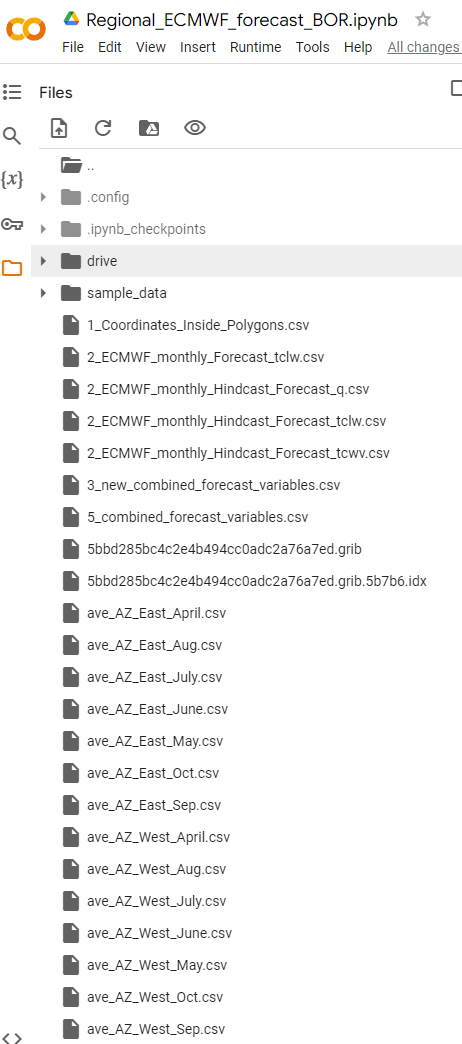

# Merge all of the forecasted data files into a single file.

In [ ]:
from functools import reduce

base_dir = '/content/'
file_prefix = '3_ECMWF_monthly_Forecast_'

all_files = os.listdir(base_dir)
forecast_files = [os.path.join(base_dir, f) for f in all_files if f.startswith(file_prefix) and f.endswith('.csv')]

dataframes = []

for file in forecast_files:
    variable_name = os.path.basename(file).replace(file_prefix, '').replace('.csv', '')
    df = pd.read_csv(file)
    df = df[['Year', 'Month', 'init_Month', 'Region', variable_name]]
    dataframes.append(df)

for df in dataframes:
    assert isinstance(df, pd.DataFrame), f"Expected DataFrame but got {type(df)}"

if len(dataframes) > 0:
    forecast_combined = reduce(lambda x, y: pd.merge(x, y, on=['Year', 'Month', 'init_Month', 'Region'], how='outer'), dataframes)
    forecast_combined.sort_values(by=['Region', 'Year', 'init_Month', 'Month'], inplace=True)
    forecast_combined.drop_duplicates(subset=['Region', 'Year', 'init_Month', 'Month'], inplace=True)

    output_file_path = f'/content/4_new_combined_forecast_variables.csv'
    forecast_combined.to_csv(output_file_path, index=False)
    print(f"Combined data saved to {output_file_path}.")
else:
    print("No forecast files found to combine.")

Combined data saved to /content/4_new_combined_forecast_variables.csv.


In [ ]:
forecast_combined

,Year,Month,init_Month,Region,tclw
40,2023,6,4,AZ_East,0.005657
41,2023,7,4,AZ_East,0.011476
42,2023,8,4,AZ_East,0.046241
43,2023,9,4,AZ_East,0.059718
44,2023,10,4,AZ_East,0.041279
...,...,...,...,...,...
35,2024,9,7,AZ_West,0.037256
36,2024,10,7,AZ_West,0.024181
37,2024,9,8,AZ_West,0.030805
38,2024,10,8,AZ_West,0.020169


### **Append `forecast_combined` to `hindcast`and update `5_combined_forecast_variables.csv`**

In [ ]:
# Append the forecast data to the hindcast data
combined_all = pd.DataFrame()
combined_all = pd.concat([hindcast_combined, forecast_combined], ignore_index=True)

combined_all.sort_values(by=['Region', 'Year', 'init_Month', 'Month'], inplace=True)
combined_all = combined_all[combined_all['Month'].isin([6, 7, 8, 9, 10])]
combined_all.drop_duplicates(subset=['Region', 'Year', 'init_Month', 'Month'], inplace=True)
output_file = f'/content/5_combined_forecast_variables.csv'
combined_all.to_csv(output_file, index=False)

print(f"Combined data saved to {output_file}")

Combined data saved to /content/5_combined_forecast_variables.csv


In [ ]:
combined_all

,Year,Month,init_Month,Region,q,tclw,tcwv
2,1981,6,4,AZ_East,0.002795,0.003504,7.585358
6,1981,7,4,AZ_East,0.004388,0.014655,12.816546
12,1981,8,4,AZ_East,0.009197,0.055658,25.289656
20,1981,9,4,AZ_East,0.010237,0.061038,26.608711
30,1981,10,4,AZ_East,0.008350,0.046045,20.242626
...,...,...,...,...,...,...,...
3699,2024,9,7,AZ_West,NaN,0.037256,NaN
3700,2024,10,7,AZ_West,NaN,0.024181,NaN
3701,2024,9,8,AZ_West,NaN,0.030805,NaN
3702,2024,10,8,AZ_West,NaN,0.020169,NaN
